# CNN 기초
---

#### linear transform에서 배운 내용을 그대로 적용한다면?
* 예시 : (1920, 1080) 해상도 RGB 이미지
> * 1단계: (1920, 1080, 3) → (1, 1920 x 1080 x 3)
> * 2단계: (1, 6220800) ⋅ (6220800, ) = (1, )


   => 적어도 620만 개의 Parameter가 생성 => 비효율적<br><br>

#### 그래서 고안된 것이 Convolutuon Layer

---

![convolution](convolution.png)
 * Convolution 연산의 출력은 입력의 형태에서 변형됨
 * 이를 방지하기 위한 개념이 Padding<br><br>


* 예시(∗ 기호는 Convolution 연산) : 
![cnn_ex](cnn_ex1.png)
> * 1단계: $(1920, 1080, 3) * (3, 16, 5, 5)_{Stride 5}  = (384, 216, 16)$ // 필터가 3개의 채널에 각각 적용되므로 (3, 16, 5, 5), stride는 필터를 적용하는 간격
> * 2단계: $(384, 216, 16) → (1, 384 x 216 x 16)$
> * 3단계: $(1, 1327104) ⋅ (1327104, ) = (1, )$


=> 620만 개에서 약 130만 개로 줄어들었다.

---
## Convolution layer의 output tensor size

>(각각의 기호를 아래와 같이 정의)
> * O: Size(width) of **output** image
> * I: Size(width) of **input** image
> * K: Size(width) of **kernels** used in the Conv layer
> * N: Number of kernels
> * S: **Stride** of the convolution operation
> * P: **Padding** size<br><br>
 
 
### **O(Size(width) of output image)는 다음과 같이 정의됨**<br>
**$$O = {{I−K+2P}\over{S}}+1$$**
출력 이미지의 채널 수는 커널의 개수(N)과 동일

---
# CNN coding

In [2]:
import tensorflow as tf

batch_size = 64
pic = tf.zeros((batch_size, 1920, 1080, 3))

print("입력 이미지 데이터:", pic.shape)

Metal device set to: Apple M2
입력 이미지 데이터: (64, 1920, 1080, 3)


2022-09-18 17:50:12.150269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-18 17:50:12.150385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
conv_layer = tf.keras.layers.Conv2D(filters=16,
                                    kernel_size=(5, 5),
                                    strides=5,
                                    use_bias=False)
conv_out = conv_layer(pic)

print("\nConvolution 결과:", conv_out.shape)
print("Convolution Layer의 Parameter 수:", conv_layer.count_params())


Convolution 결과: (64, 384, 216, 16)
Convolution Layer의 Parameter 수: 1200


In [4]:
flatten_out = tf.keras.layers.Flatten()(conv_out)
print("\n1차원으로 펼친 데이터:", flatten_out.shape)


1차원으로 펼친 데이터: (64, 1327104)


In [5]:
linear_layer = tf.keras.layers.Dense(units=1, use_bias=False)
linear_out = linear_layer(flatten_out)

print("\nLinear 결과:", linear_out.shape)
print("Linear Layer의 Parameter 수:", linear_layer.count_params())


Linear 결과: (64, 1)
Linear Layer의 Parameter 수: 1327104


### 그러나 여전히 문제점이 존재
#### * 5 X 5라는 필터 사이즈는 object detection을 위한 유의미한 정보를 담아내기에는 너무 작은 사이즈이다.
#### * 이미 Stride를 5로 주고 있었기 때문에 파라미터를 줄어드는 효과는 발생했지만 찾고자 하는 object가 필터 경계선에 걸려서 인식하지 못할 우려가 있다.


=> 해결책으로 Pooling을 적용

---


## Receptive Field / Pooling <br>
### 1. 수용 영역(Receptive Field)
Neural Network의 출력부가 유의미한 정보를 얻기 위해서는 커버하는 입력 데이터의 Receptive Field가 충분히 커서 그 안에 detect해야 할 object의 특성이 제대로 포함되어 있어야 정확한 detection이 가능

* 7 X 7의 이미지에 3 X 3의 필터로 Convolution한 그림
![receptive field](receptive.png)
 * Convolution 레이어를 한 번 통과한 후 Output의 빨간색 포인트는 원본 이미지의 좌상단 3 X 3만큼의 입력만을 수용하게 됨.<br>
 * 즉 이 포인트의 Receptive Field의 크기는 Filter size와 정확히 같음.<br><br>
 
 
 
 ### 2. 풀링(Pooling) : 여기서는 Max Pooling을 살펴볼 것
 * #### Max Pooling의 이점

 ![max_pooling](max_pooling.png)
  * ##### translational invariance 효과<br>
이미지는 약간의 상하좌우 시프트가 생긴다고 해도 내용상 동일한 특징을 가짐.<br>Max Pooling을 통해 인접한 영역 중 가장 특징이 두드러진 영역 하나를 뽑는 것은 오히려 약간의 시프트 효과에도 불구하고 동일한 특징을 안정적으로 잡아낼 수 있는 긍정적 효과가 있음.<br>따라서 오히려 object 위치에 대한 오버피팅을 방지하고 안정적인 특징 추출 효과를 가져옴.<br><br>
  * ##### Non-linear 함수와 동일한 피처 추출 효과<br>
Relu와 같은 Non-linear 함수도 마찬가지로 많은 하위 레이어의 연산 결과를 무시하게 됨.<br>하지만 중요한 피처만을 상위 레이어로 추출하면서 결과적으로 분류기의 성능을 높임.<br>Min/Max Pooling도 이와 마찬가지.<br><br>
  * ##### Receptive Field 극대화 효과<br>
Max Pooling이 없이도 Receptive Field를 크게 하려면 Convolutional 레이어를 아주 많이 쌓아야 함.<br>그 결과 **큰 파라미터 사이즈로 인한 오버피팅, 연산량 증가, Gradient Vanishing 등의 문제**를 감수해야 함.<br>이런 문제를 효과적으로 해결하는 방법으로 꼽히는 두 가지 중 하나가 Max Pooling 레이어 사용.(다른 하나로는 Dilated Convolution)<br>
참조 : [receptive field와 dilated convolution](https://blog.naver.com/sogangori/220952339643)

----

----

## Deconvolution Layer : Auto Encoder 예시

#### Convolution의 결과를 역재생해서 원본 이미지와 최대한 유사한 정보를 복원해 내는 Auto Encoder
* autoencoder 구조
![autoencoder](autoencoder.png)

<br><br>
#### * 목표 : MNIST 데이터셋을 입력으로 받아 그대로 복원하는 Auto Encoder를 구성
> 1. 패키지 임포트 및 MNIST 데이터셋 로딩
> 2. AutoEncoder 모델 구성
> 3. AutoEncoder 모델 훈련
> 4. AutoEncoder Reconstruction Test

### 1. 데이터셋 호출

In [7]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import json
import matplotlib.pyplot as plt #for plotting

# MNIST 데이터 로딩
(x_train, _), (x_test, _) = mnist.load_data()    # y_train, y_test는 사용하지 않습니다.

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#### y_train, y_test를 사용하지 않는다는 것을 알 수 있음
#### 이는 AutoEncoder가 수행하는 Image Reconstruction Task는 x_train의 label이 바로 x_train 자신이 되기 때문(정답을 가지고 있는 셈)
<br>


### 2. AutoEncoder 모델 구성

In [8]:
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
encode_pool_layer_1 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
encode_pool_layer_2 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu', padding='same')
encode_pool_layer_3 = MaxPooling2D((2, 2), padding='same')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)
encoded = encode_pool_layer_3(encoded)



# AutoEncoder 모델 구성 - Decoder 부분
decode_conv_layer_1 = Conv2D(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2D(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)



# AutoEncoder 모델 정의
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 4)           292   

### 3. 모델 적용

In [9]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


2022-09-18 18:16:11.805580: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-18 18:16:12.006320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.6891

2022-09-18 18:16:20.499816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 9s 30ms/step - loss: 0.6891 - val_loss: 0.6885
Epoch 2/10
235/235 [==============================] - 7s 28ms/step - loss: 0.6877 - val_loss: 0.6868
Epoch 3/10
235/235 [==============================] - 6s 27ms/step - loss: 0.6857 - val_loss: 0.6846
Epoch 4/10
235/235 [==============================] - 6s 27ms/step - loss: 0.6831 - val_loss: 0.6816
Epoch 5/10
235/235 [==============================] - 7s 28ms/step - loss: 0.6796 - val_loss: 0.6776
Epoch 6/10
235/235 [==============================] - 6s 28ms/step - loss: 0.6748 - val_loss: 0.6719
Epoch 7/10
235/235 [==============================] - 7s 28ms/step - loss: 0.6679 - val_loss: 0.6636
Epoch 8/10
235/235 [==============================] - 7s 28ms/step - loss: 0.6577 - val_loss: 0.6511
Epoch 9/10
235/235 [==============================] - 7s 28ms/step - loss: 0.6416 - val_loss: 0.6308
Epoch 10/10
235/235 [==============================] - 7s 29ms/step - loss: 0.6143 - val_loss: 0.5949


#### *  상기했듯 y_train이 들어가야 할 자리에 x_train이 들어가 있음을 유의<br>
#### *  또한 **binary_crossentropy**를 사용하고 있음. 
이는 모든 dim에서 0~1 사이의 값을 가지는 입력 데이터와 출력 데이터(마지막 출력이 sigmoid로 제어되고 있음을 유의) 사이의 분포가 최대한 유사하기를 바라기 때문.
> ##### +binary_crossentropy에서 from_logits 옵션<br>
> from_logits옵션을 따로 안 넣으면 output layer에 sigmoid를 추가해야 함.<br>
> from_logits=True를 추가 했다면, 마지막에 sigmoid activation을 하지 않아도 됨)

> ##### +binary_crossentropy와 categorical_crossentropy의 차이
> 결론적으로 둘의 차이는 **output layer가 sigmoid이냐 softmax이냐**의 차이<br><br>
>> binary_crossentropy : <U>label 값이 0 or 1(이진 분류)</U> 이면서 **sigmoid**_cross_entropy가 loss<br>
>> categorical_crossentropy : <U>label 값이 [0,1] or [1,0](다중 분류)</U> 의 형태이면서 **softmax**_cross_entropy가 loss<br>
>> sparse_categorical_crossentropy : <U>label 값이 0 or 1(이진 분류)</U> 이면서 **softmax**_cross_entropy를 사용


### 4. 결과 시각화

2022-09-18 18:32:18.711033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 281ms/step


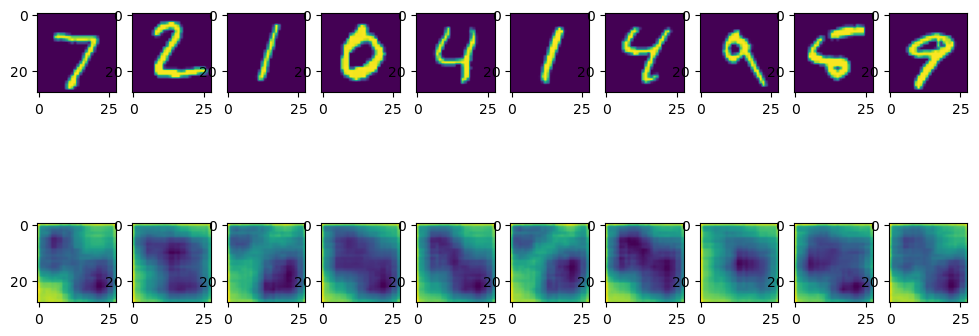

In [10]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])

#### 만족스럽지 않은 결과이지만 동일한 Decoder 네트워크 구조를 가지고도 Variational Autoencoder나 DCGAN 등은 훨씬 훌륭한 이미지를 생성함
#### 엄밀히 말해, 이것은 Convolution의 수학적 역연산으로서의 Deconvolution과는 다름.. 오히려 정방향의 Convolution 연산을 통해 원본 이미지와 가까운 이미지를 재생해 내는 효과를 구현한 것

---

## Upsampling
#### 지금까지 Max pooling 레이어를 통해 Downsampling을 시도해 왔다면, Upsampling 레이어는 그 반대 작업을 수행함.
<br>크게 3가지 방법이 존재한다.

* Nearest Neighbor : 복원해야 할 값을 가까운 값으로 복제.
* Bed of Nails : 복원해야 할 값을 0으로 처리.
* Max Unpooling : Max Pooling 때 버린 값을 실은 따로 기억해 두었다가 그 값으로 복원.<br><br>



참고 자료
> [Transposed Convolutional Layer은 무엇인가?](https://velog.io/@hayaseleu/Transposed-Convolutional-Layer%EC%9D%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80)<br>
> [Up-sampling with Transposed Convolution 번역](https://zzsza.github.io/data/2018/06/25/upsampling-with-transposed-convolution/)

---
### 심화 : Transposed Convolution을 활용한 모델 설계

```Python
from tensorflow.keras.layers import Conv2DTranspose

# Conv2DTranspose를 활용한  AutoEncoder 모델
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu')
encode_pool_layer_1 = MaxPooling2D((2, 2))
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu')
encode_pool_layer_2 = MaxPooling2D((2, 2))
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분  - 
decode_conv_layer_1 = Conv2DTranspose(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2DTranspose(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

# AutoEncoder 모델 정의
autoencoder = Model(input_img, decoded)
autoencoder.summary()
```